# Analysis of courier daily activity dataset

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Import necessary packages</p>
</div>

In [528]:
import pandas as pd
import numpy as np
import os
from scipy import fftpack  # or 'fft'
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from wolt_test_assignment.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta


%matplotlib inline



<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define utility functions 
 </p>
</div>

In [529]:
def plot_prediction(y_test_original, predicted_courier_number_original, start_date):
    """
    Plot the real and predicted values for courier partners online.

    Parameters:
    y_test_original (array-like): The original test values (real values).
    predicted_courier_number_original (array-like): The predicted values from the model.

    Returns:
    None
    """
    date_range = pd.date_range(start=start_date, periods=len(y_test_original))
    plt.plot(date_range, y_test_original, color='red', marker='+', label="Real")
    plt.plot(date_range, predicted_courier_number_original, color="blue", marker='o', label="Predicted")
    plt.title("Prediction")
    plt.xlabel("Day")
    plt.ylabel("Number of Courier Partners Online")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


## Dataset cleaning

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Load and examine raw dataset
 </p>
</div>

In [530]:
file_name = os.path.join(RAW_DATA_DIR, "daily_cp_activity_dataset.csv")
df_daily_activity = pd.read_csv(file_name)

In [531]:
df_daily_activity.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49,18.27,0.57,0.0
1,2021-05-02,927,19.88,0.55,0.0
2,2021-05-03,40,16.88,0.60,0.0
3,2021-05-04,51,21.88,0.53,0.0
4,2021-05-05,50,21.11,0.54,0.0


In [532]:
df_daily_activity['date'] = pd.to_datetime(df_daily_activity['date'])

Text(0, 0.5, 'Courier number')

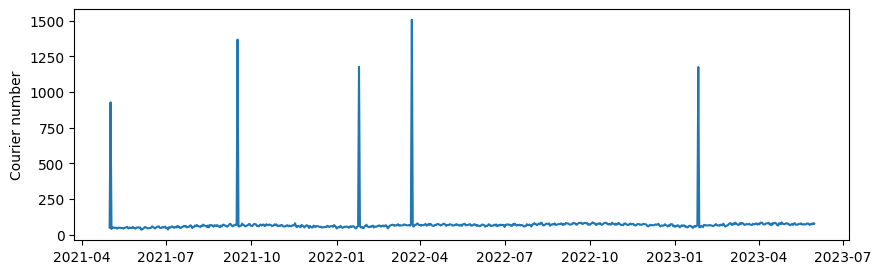

In [533]:
plt.figure(figsize=(10, 3)) 
plt.plot (df_daily_activity["date"], df_daily_activity["courier_partners_online"])
plt.ylabel("Courier number")

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>The data have several outliers. Let's get rid of them, as well as from the several non-defined data
 </p>
</div>

In [534]:
anomaly_threshold = 500
df_daily_activity_cleaned = df_daily_activity.copy(deep= True)
df_daily_activity_cleaned.loc [df_daily_activity['courier_partners_online']>500, 'courier_partners_online'] = None
df_daily_activity_cleaned = df_daily_activity_cleaned.ffill()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Look at different time series to see clear correlation between courier activity, temperature and percipitation.
 </p>
</div>

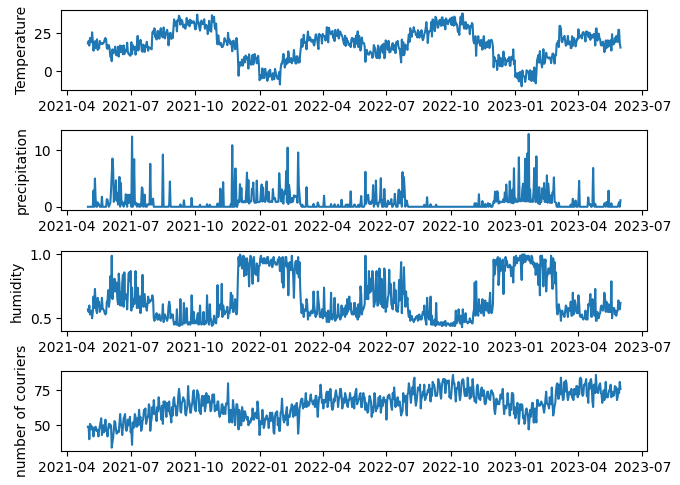

In [535]:
fig, ax = plt.subplots(4,1, figsize =(7,5))
ax[0].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["temperature"])
ax[0].set_ylabel("Temperature")

ax[1].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["precipitation"])
ax[1].set_ylabel("precipitation")

ax[2].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["relative_humidity"])
ax[2].set_ylabel("humidity")

ax[3].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["courier_partners_online"])
ax[3].set_ylabel("number of couriers")

fig.tight_layout()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Now since data is cleaned we can add "day_of_week" variables
 </p>
</div>

In [536]:

df_daily_activity_cleaned['day_of_week'] = df_daily_activity_cleaned['date'].dt.dayofweek
df_daily_activity_cleaned = pd.get_dummies(df_daily_activity_cleaned, columns=['day_of_week'])
df_daily_activity_cleaned.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2021-05-01,49.0,18.27,0.57,0.0,False,False,False,False,False,True,False
1,2021-05-02,49.0,19.88,0.55,0.0,False,False,False,False,False,False,True
2,2021-05-03,40.0,16.88,0.60,0.0,True,False,False,False,False,False,False
3,2021-05-04,51.0,21.88,0.53,0.0,False,True,False,False,False,False,False
4,2021-05-05,50.0,21.11,0.54,0.0,False,False,True,False,False,False,False


## Exploratory data analysis

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us look at correlations 
 </p>
</div>

In [537]:
# Correlation matrix between features
correlation_matrix = df_daily_activity_cleaned.corr()

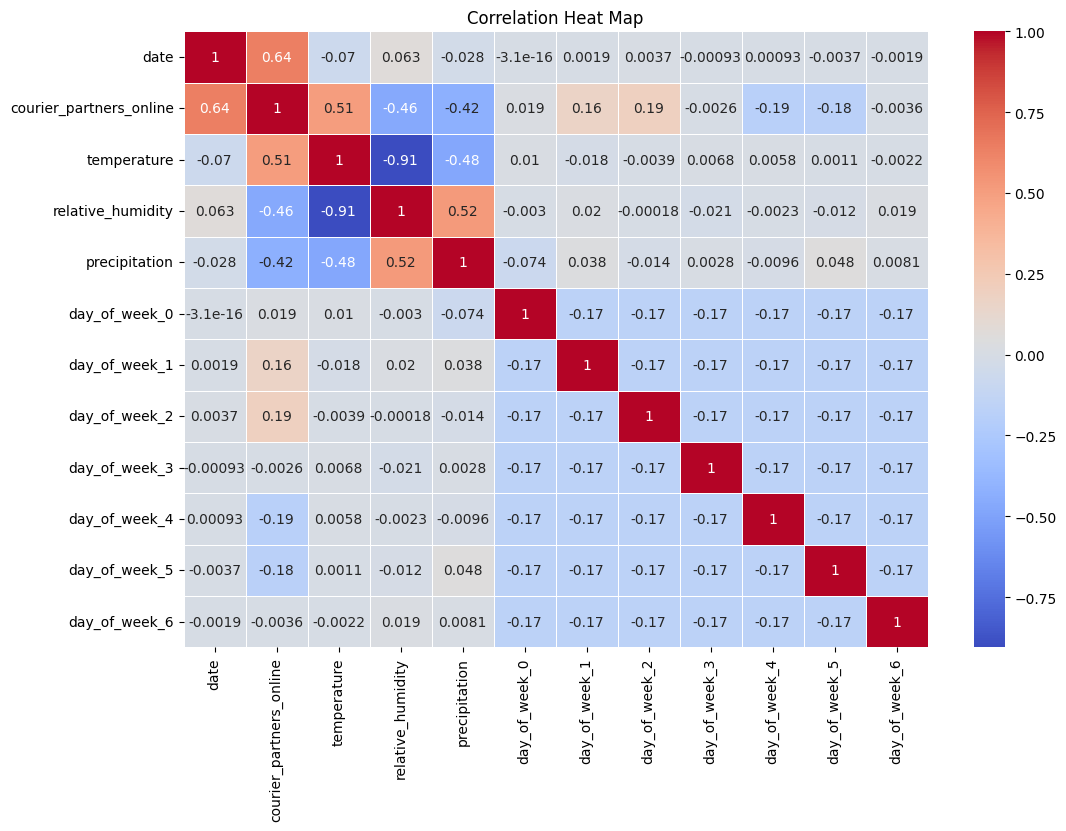

In [538]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heat Map')
plt.show()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us look at dependence between different features. Three panels below show that 'temperature', 'relative_humidity' and 'precipitation' are almost deterministically connected.
 </p>
</div>

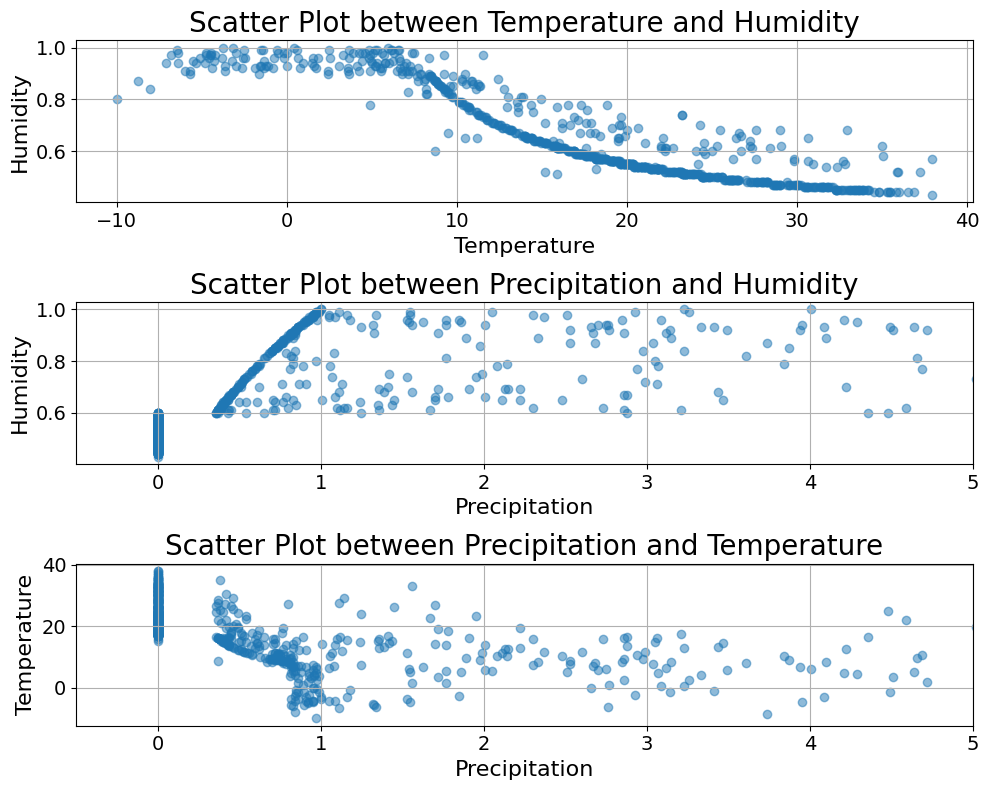

In [539]:
# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Scatter plot between Temperature and Humidity
axs[0].scatter(df_daily_activity_cleaned['temperature'], df_daily_activity_cleaned['relative_humidity'], alpha=0.5)
axs[0].set_title('Scatter Plot between Temperature and Humidity', fontsize=20)
axs[0].set_xlabel('Temperature', fontsize=16)
axs[0].set_ylabel('Humidity', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid(True)

# Scatter plot between Precipitation and Humidity
axs[1].scatter(df_daily_activity_cleaned['precipitation'], df_daily_activity_cleaned['relative_humidity'], alpha=0.5)
axs[1].set_title('Scatter Plot between Precipitation and Humidity', fontsize=20)
axs[1].set_xlabel('Precipitation', fontsize=16)
axs[1].set_ylabel('Humidity', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.5, 5)
axs[1].grid(True)

# Scatter plot between Precipitation and Temperature
axs[2].scatter(df_daily_activity_cleaned['precipitation'], df_daily_activity_cleaned['temperature'], alpha=0.5)
axs[2].set_title('Scatter Plot between Precipitation and Temperature', fontsize=20)
axs[2].set_xlabel('Precipitation', fontsize=16)
axs[2].set_ylabel('Temperature', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].set_xlim(-0.5, 5)
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

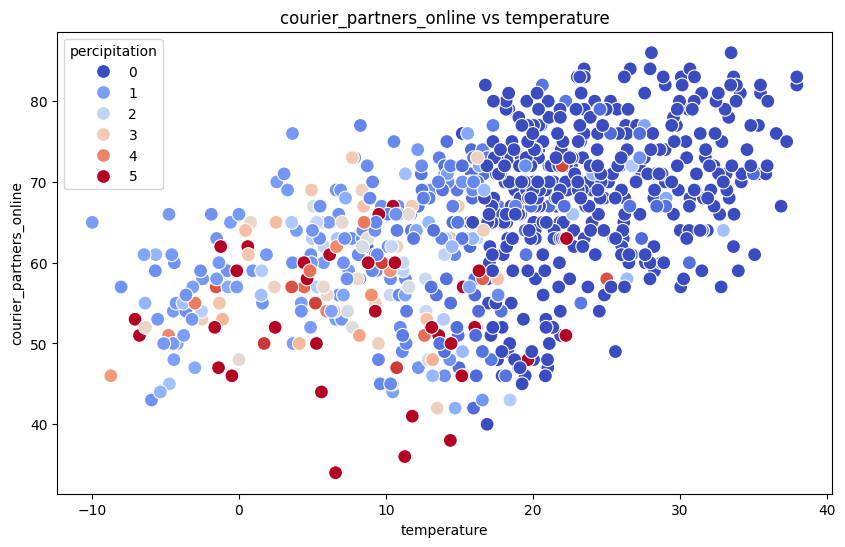

In [540]:
# Create a colorized scatter plot with a specific palette
df_daily_activity_cleaned_1 = df_daily_activity_cleaned.copy(deep=True)
df_daily_activity_cleaned_1["precipitation"] = df_daily_activity_cleaned_1['precipitation'].apply(lambda x: 5 if x > 5 else x)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_daily_activity_cleaned_1, x='temperature', y='courier_partners_online', hue='precipitation', palette='coolwarm', s=100)
plt.title('courier_partners_online vs temperature')
plt.xlabel('temperature')
plt.ylabel('courier_partners_online')
plt.legend(title='percipitation')
plt.show()

## Domain-Relevant feature engineering

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>From the correlation heat map above we see that important features are 'precipitation', 'temperature' and 'day_of_week' variables. 
    For the Dataset we use historical values of these variables meaning their values in the sertain number of days preceding the day at which target variable, that is 'courier_partners_online' is taken. The values of 'courier_partners_online' in preceding days is also included as featuers.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Thus, features are the values of variables : 'temperature',  'precipitation', 'day_of_week_i' , 'courier_partners_online' in the N previous days. 
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
  <p> 
    To train, test, and validate the model, we will split the data into training, validation, and testing sets. We will use the first 70% portion of the data for training, the middle portion 10% for validation, and the last 20% portion for testing. 
  </p>
</div>

In [541]:
duration_train = int(0.6*df_daily_activity_cleaned.shape [0])
duration_val = int(0.2*df_daily_activity_cleaned.shape [0])
start_date = (df_daily_activity_cleaned["date"].iloc[0])

# Calculate the validation start date
SPLIT_DATE_TRAIN_END = start_date + timedelta(duration_train)
SPLIT_DATE_TEST = start_date + timedelta(duration_train) + timedelta(duration_val)

SPLIT_DATE_TRAIN_END = SPLIT_DATE_TRAIN_END.strftime("%Y-%m-%d")
SPLIT_DATE_TEST = SPLIT_DATE_TEST.strftime("%Y-%m-%d")

print(SPLIT_DATE_TRAIN_END, SPLIT_DATE_TEST)


2022-07-31 2022-12-30


In [542]:
SPLIT_DATE_TEST = "2023-01-01"

SPLIT_DATE_TRAIN_END = "2022-10-15"

#SPLIT_DATE_TRAIN_END = "2022-07-31"

In [543]:
# Prepare the datasets
features = ['courier_partners_online', 'precipitation', 'temperature'] + [col for col in df_daily_activity_cleaned.columns if col.startswith('day_of_week')]
total_set = df_daily_activity_cleaned[features].values
training_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] < SPLIT_DATE_TRAIN_END].values

val_set = df_daily_activity_cleaned[(df_daily_activity_cleaned['date'] >= SPLIT_DATE_TRAIN_END) & (df_daily_activity_cleaned['date'] < SPLIT_DATE_TEST)][features].values

test_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] >= SPLIT_DATE_TEST].values

SC = StandardScaler()

# Fit the scaler on the total set and transform both training and test sets
SC.fit(total_set)
total_set_scaled = SC.transform(total_set)
training_set_scaled = SC.transform(training_set)
test_set_scaled = SC.transform(test_set)
val_set_scaled = SC.transform(val_set)


## LSTM model definition

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define RNN model, namely the Long-Short-Term_Memory multilayer model for time series forecasting
 </p>
</div>

In [544]:
def create_regressor(input_shape, n_steps):
    """
    Create and compile an LSTM model with Dropout regularization.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    model (Sequential): Compiled LSTM model.
    """
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    regressor.add(Dropout(0.3))

    # Second LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=80, return_sequences=True))
    regressor.add(Dropout(0.1))

    # Third LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Fourth LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=30))
    regressor.add(Dropout(0.3))

    # Output layer
    regressor.add(Dense(units=n_steps))

    # Compile the model
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    return regressor

In [545]:
# Example usage
input_shape = (40, 10)  # Example input shape (timesteps, features)
n_steps = 1  # Example number of steps to predict
model = create_regressor(input_shape, n_steps)
model.summary()

c:\Users\mikes\Documents\STUDY\MLOps\WoltTestAssignment\wolt_test_assignment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_156 (LSTM)                 │ (None, 40, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_157 (LSTM)                 │ (None, 40, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 40, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_158 (LSTM)                 │ (None, 40, 50)         │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_159 (LSTM)                 │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,271 (540.12 KB)

 Trainable params: 138,271 (540.12 KB)

 Non-trainable params: 0 (0.00 B)

## Prediction : Next-Day and Multiple-Day tasks

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Next-Day task consists of predicting the 'courier_partners_online' variable for the next day based on the information available for the previous days.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Multiple-Day task consists of predicting the 'courier_partners_online' variable values for the several next days based on the information available for the previous days.
 </p>
</div>

## Predicting courier numner for the Next-Day task

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us perform forecasting of the courier numnber for the Next-Day task. First, prepare the training, validation and test datasets.
 </p>
</div>

### Analysis with Linear Regression models

In [546]:
# Prepare the training data
training_days = 40  # Number of past days to use for prediction
n_steps = 1  # Number of future steps to predict

X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
 
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

if n_steps == 1:
    y_train = y_train.flatten()  # Single-output regression
    model = LinearRegression()
else:
    model = MultiOutputRegressor(LinearRegression())  # Multi-step regression

model.fit(X_train, y_train)

LinearRegression()

In [547]:
# Prepare the test data
X_test = []
y_test = []
y_test_original = []
for i in range(training_days, len(test_set_scaled) - n_steps + 1):
    #X_test.append(test_set_scaled[i - training_days:i])
    
    y_test_original.append(test_set[i:i + n_steps, 0])
    y_test.append(training_set_scaled[i:i + n_steps, 0])
    X_test.append(test_set_scaled[i - training_days:i].flatten())  # Flatten for MultiOutputRegressor input

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_original = np.array(y_test_original)

# Make predictions on the test set
predicted_courier_number = model.predict(X_test)
    
#y_test_original = test_target[ start_ind + training_days: start_ind + training_days + n_steps ].flatten() 
#predicted_courier_number = predicted_courier_number[-1, :].flatten()   
          
# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], training_set_scaled.shape[1]))   
        
predicted_full[:, 0] = predicted_courier_number.flatten()
   
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]

integer_predicted_courier_number = np.round(predicted_courier_number_original)

split_date_dt = datetime.strptime(SPLIT_DATE_TEST, "%Y-%m-%d")
start_date = split_date_dt + timedelta(training_days)
start_date_str = start_date.strftime("%Y-%m-%d")

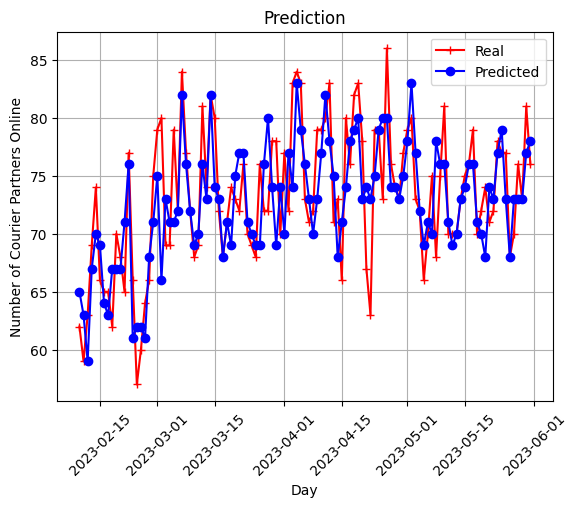

In [548]:
plot_prediction(y_test_original, integer_predicted_courier_number, start_date_str)

### Feature Importance Analysis

In [549]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

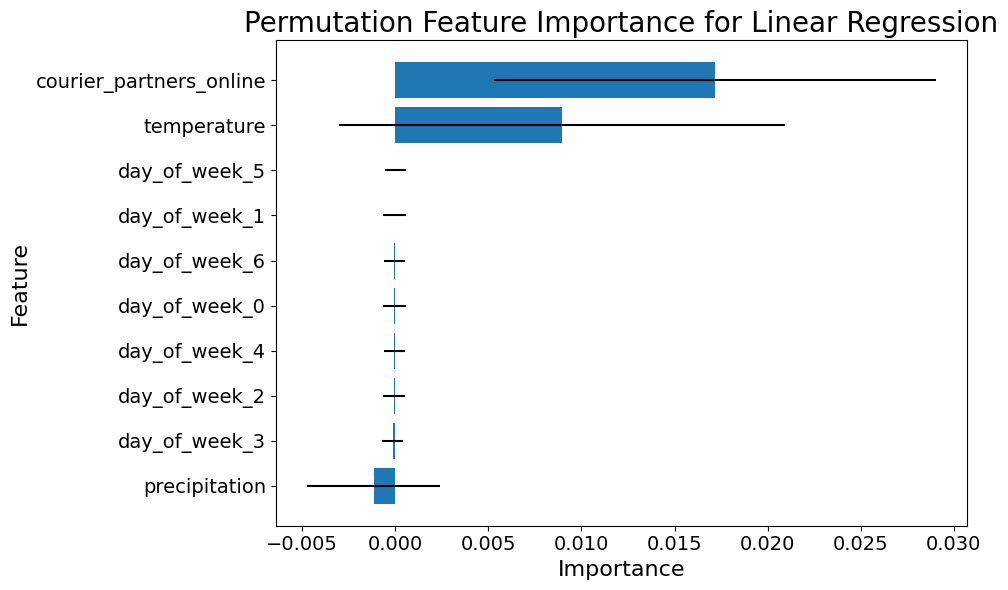

In [550]:
feature_number = 10 
feature_names = ['courier_partners_online', 'precipitation', 'temperature', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

mean_coefs = np.mean( np.reshape(result.importances_mean, (training_days, feature_number) ), axis=0)   
std_coefs = np.mean( np.reshape(result.importances_std, (training_days, feature_number) ), axis=0)   

#mean_coefs = np.reshape(result.importances_mean, (training_days, feature_number) ) [39,:]
#std_coefs = np.reshape(result.importances_std, (training_days, feature_number) ) [39,:]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_coefs,
    'Importance_std': std_coefs
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Importance_std'])
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Permutation Feature Importance for Linear Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analysis with LSTM model

In [551]:
# Prepare the training data
training_days = 40  # Number of past days to use for prediction
n_steps = 1  # Number of future steps to predict

X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i, 0])  # Only 'courier_partners_online' as target

X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare the test set
X_test = []
y_test = []
y_test_original = []

for i in range(training_days, len(test_set_scaled)):
    X_test.append(test_set_scaled[i - training_days:i])
    y_test.append(test_set_scaled[i, 0])  # Only 'courier_partners_online' as target
    y_test_original.append(test_set[i, 0])

# Prepare the validation set
X_val = []
y_val = []

for i in range(training_days, len(val_set_scaled)):
    X_val.append(val_set_scaled[i - training_days:i])
    y_val.append(val_set_scaled[i, 0])  # Only 'courier_partners_online' as target
    
X_test, y_test, y_test_original = np.array(X_test), np.array(y_test), np.array(y_test_original)
X_val, y_val = np.array(X_val), np.array(y_val)



In [552]:
# Train the model   
input_shape = (X_train.shape[1], X_train.shape[2])
regressor = create_regressor(input_shape, n_steps=1)
# Train the model and record the history
history = regressor.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/20


c:\Users\mikes\Documents\STUDY\MLOps\WoltTestAssignment\wolt_test_assignment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.6352 - val_loss: 0.4200
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.3512 - val_loss: 0.2771
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3427 - val_loss: 0.3034
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3354 - val_loss: 0.3026
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3466 - val_loss: 0.2884
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.3022 - val_loss: 0.2683
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.3224 - val_loss: 0.2688
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.2982 - val_loss: 0.2619
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 0.3120 - val_loss: 0.2233
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.2306 - val_loss: 0.1947
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - loss: 0.2643 - val_loss: 0.2172
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.2487 -

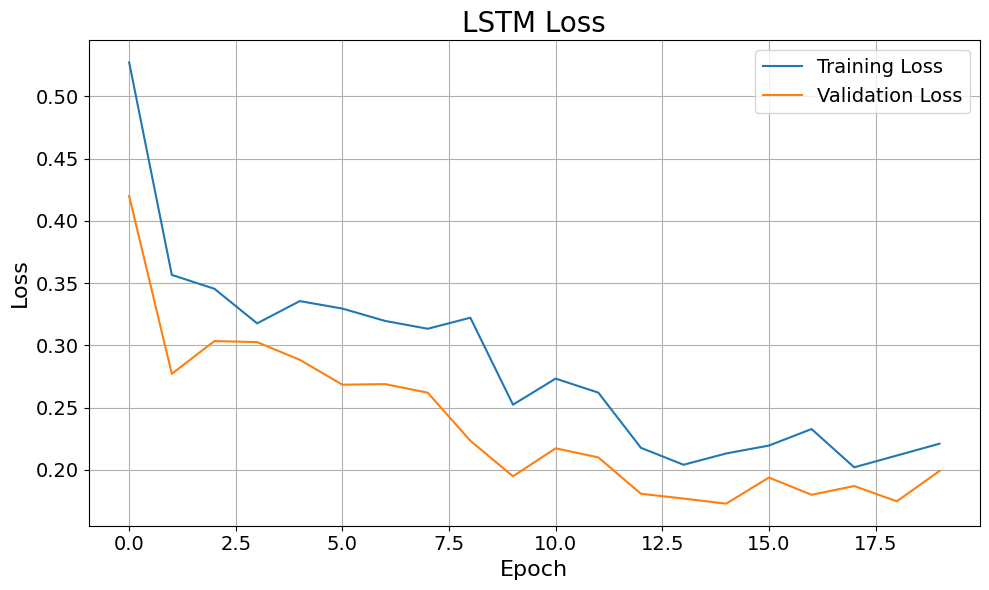

In [553]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Set font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [554]:
# Assuming X_test is prepared similarly to X_train
predicted_courier_number = regressor.predict(X_test)

# Create a placeholder array for inverse transform
# The second dimension should match the number of features (e.g., 2 for 'courier_partners_online' and 'precipitation')
predicted_full = np.zeros((predicted_courier_number.shape[0], total_set.shape[1]))

predicted_full[:, 0] = predicted_courier_number.flatten()

# Debug the placeholder shape
print("Predicted_full shape:", predicted_full.shape)  # Should match the shape required for SC.inverse_transform

# Inverse transform the predictions
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predictions= np.round(predicted_courier_number_original).astype(int)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step 
Predicted_full shape: (111, 10)


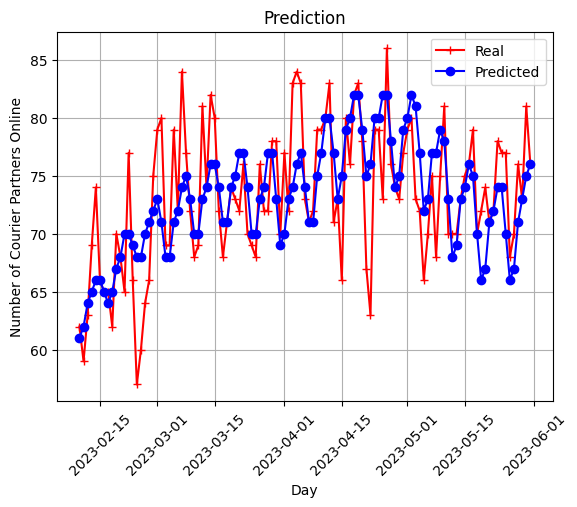

In [555]:
   
# visualize our test and predicted data
plot_prediction(y_test_original, integer_predictions, start_date_str)


## Predicting courier numnber for the Multiple-Day task

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us perform multiple-step forecasting to predict courier numbers for several (20) future days.  First, prepare the training, validation and test datasets.
 </p>
</div>

### Analysis with Linear Regression models

In [556]:
training_days = 40  # Number of past days to use for prediction
n_steps = 20  # Number of future steps to predict

X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
 
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

if n_steps == 1:
    y_train = y_train.flatten()  # Single-output regression
    model = LinearRegression()
else:
    model = MultiOutputRegressor(LinearRegression())  # Multi-step regression

model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [557]:
# Prepare the test data
X_test = []
y_test = []
for i in range(training_days, len(test_set_scaled) - n_steps + 1):
    #X_test.append(test_set_scaled[i - training_days:i])
    y_test.append(training_set_scaled[i:i + n_steps, 0])
    X_test.append(test_set_scaled[i - training_days:i].flatten())  # Flatten for MultiOutputRegressor input

y_test_original = np.array(test_set[i:i+ n_steps, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Make predictions on the test set
predicted_courier_number = model.predict(X_test)
    
#y_test_original = test_target[ start_ind + training_days: start_ind + training_days + n_steps ].flatten() 
predicted_courier_number = predicted_courier_number[-1, :].flatten()   
          
# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], training_set_scaled.shape[1]))   
        
predicted_full[:, 0] = predicted_courier_number.flatten()
   
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predicted_courier_number = np.round(predicted_courier_number_original)

split_date_dt = datetime.strptime(SPLIT_DATE_TEST, "%Y-%m-%d")
start_date = split_date_dt + timedelta( len(test_set_scaled) - n_steps)
start_date_str = start_date.strftime("%Y-%m-%d")

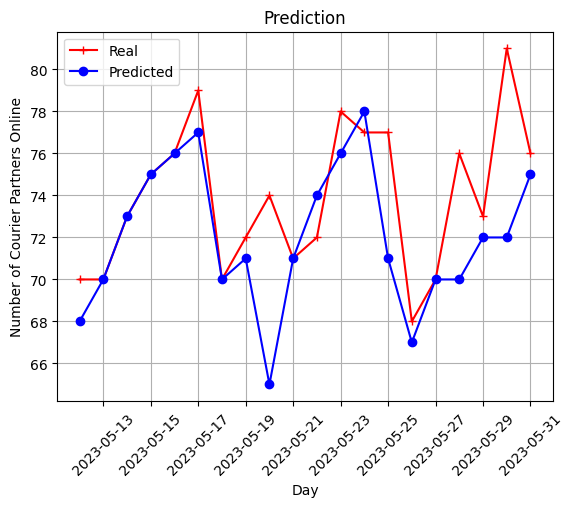

In [558]:
plot_prediction(y_test_original, integer_predicted_courier_number, start_date_str)

### Feature importance analysis

In [559]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

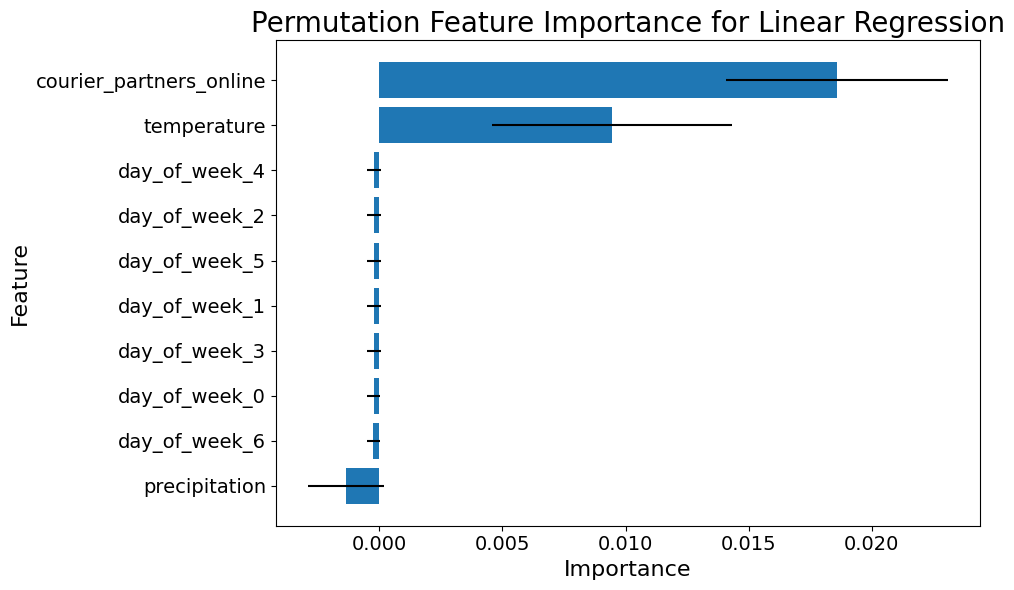

In [560]:
feature_number = 10 
feature_names = ['courier_partners_online', 'precipitation', 'temperature', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

mean_coefs = np.mean( np.reshape(result.importances_mean, (training_days, feature_number) ), axis=0)   
std_coefs = np.mean( np.reshape(result.importances_std, (training_days, feature_number) ), axis=0)   

#mean_coefs = np.reshape(result.importances_mean, (training_days, feature_number) ) [39,:]
#std_coefs = np.reshape(result.importances_std, (training_days, feature_number) ) [39,:]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_coefs,
    'Importance_std': std_coefs
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Importance_std'])
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Permutation Feature Importance for Linear Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analysis with LSTM model

In [561]:
training_days = 40  # Number of past days to use for prediction
n_steps = 20  # Number of future steps to predict

# Prepare the training data
X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])  # Predict 'n_steps' future values of 'courier_partners_online'    

X_train, y_train = np.array(X_train), np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)  # Flatten for Dense layer

# Prepare the test data
X_test = []
for i in range(training_days, len(test_set_scaled) - n_steps + 1):
    X_test.append(test_set_scaled[i - training_days:i])  # Flatten for MultiOutputRegressor input

y_test_original = np.array(test_set[i:i+ n_steps, 0])
X_test = np.array(X_test)

# Prepare the validation data
X_val = []
y_val = []
for i in range(training_days, len(val_set_scaled) - n_steps + 1):
    X_val.append(val_set_scaled[i - training_days:i])  # Flatten for MultiOutputRegressor input
    y_val.append(val_set_scaled[i:i + n_steps, 0])  # Predict 'n_steps' future values of 'courier_partners_online'

y_val_original = np.array(val_set[i:i+ n_steps, 0])
X_val, y_val = np.array(X_val), np.array(y_val)


In [562]:
# train model
input_shape = (X_train.shape[1], X_train.shape[2])
regressor = create_regressor(input_shape, n_steps)
history= regressor.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100


c:\Users\mikes\Documents\STUDY\MLOps\WoltTestAssignment\wolt_test_assignment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.7005 - val_loss: 0.2669
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5372 - val_loss: 0.2916
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4513 - val_loss: 0.4162
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4107 - val_loss: 0.7405
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3604 - val_loss: 0.8400
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3565 - val_loss: 1.0335
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3381 - val_loss: 0.7438
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.3310 - val_loss: 0.7972
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3308 - val_loss: 0.7983
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3306 - val_loss: 1.0403
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3227 - val_loss: 0.8062
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.

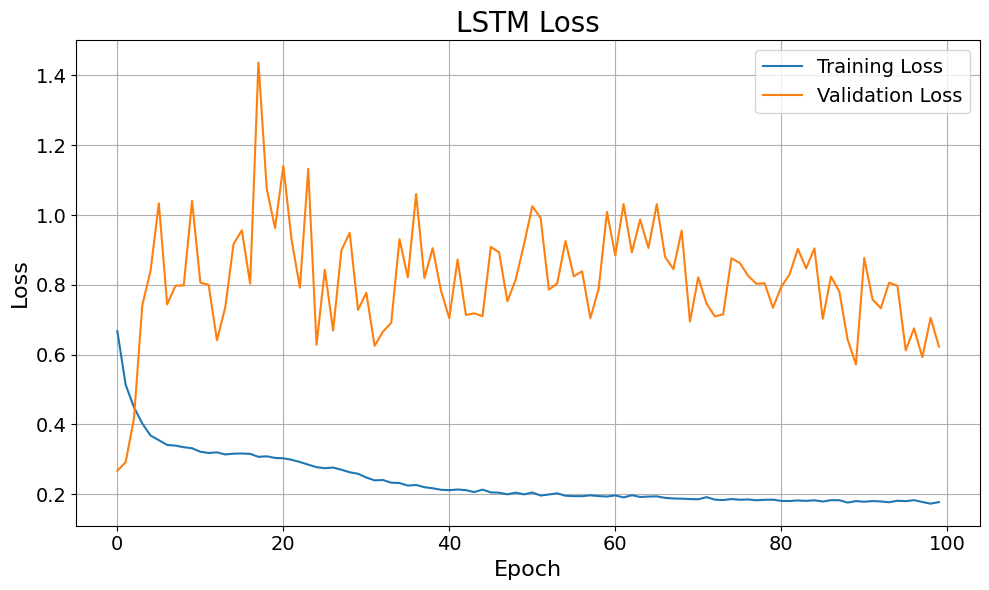

In [563]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Set font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [564]:

# Ensure the shape of X_test matches the model input
print("X_test shape:", X_test.shape)  # Should be (samples, training_days, features)

# Make predictions on the test set
predicted_courier_number = regressor.predict(X_test) 
print("Predicted courier number shape:", predicted_courier_number.shape)  # Should be (samples, n_steps)

predicted_courier_number = predicted_courier_number[-1, :].flatten()
print("Predicted courier number shape:", predicted_courier_number.shape)  # Should be (samples, n_steps)

# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], total_set.shape[1]))
predicted_full[:, 0] = predicted_courier_number.flatten()

# Debug the placeholder shape
print("Predicted_full shape:", predicted_full.shape)  # Should match the shape required for SC.inverse_transform

# Inverse transform the predictions
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predictions= np.round(predicted_courier_number_original).astype(int)

# Print shapes for debugging
print("Predicted_original shape:", predicted_original.shape)
print("Predicted_courier_number_original shape:", predicted_courier_number_original.shape)

X_test shape: (92, 40, 10)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Predicted courier number shape: (92, 20)
Predicted courier number shape: (20,)
Predicted_full shape: (20, 10)
Predicted_original shape: (20, 10)
Predicted_courier_number_original shape: (20,)


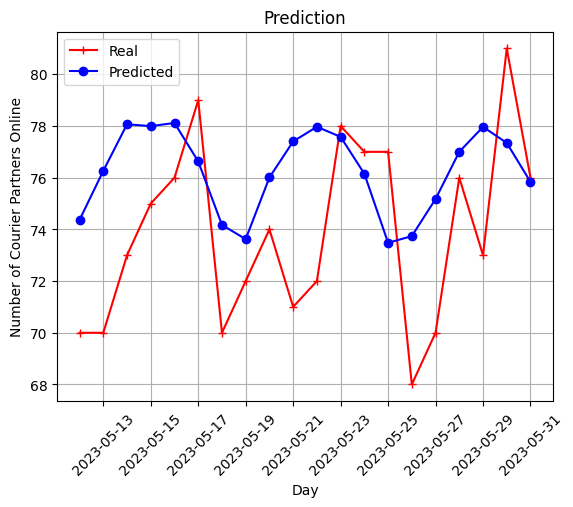

In [565]:
    
# now we'll use this function to visualize our test and predicted data

plot_prediction(y_test_original, predicted_courier_number_original, start_date_str)

## Metrics

To measure performace of prediction we use several metrices descibed below. These metrices are calculated using scripts as described in README.md file.

Mean Absolute Error (MAE)
$$
    \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Mean Squared Error (MSE)
$$
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 
$$

Root Mean Squared Error (RMSE)
$$ 
    \text{RMSE} = \sqrt{
        \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
        } 
$$

Signal-to-Noise Ratio (SNR)

$$
 \text{SNR (dB)} = 10 \log_{10} 
 \left( 
    \frac{
          \sum_{i=1}^{n} \hat{y}_i^2
        }
        { 
           \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 
        } 
 \right) 
$$

Here
-$ y_i $ and  $ \hat{y}_i $ The actual value of courier numbers on the (i)-th day.
- $ \hat{y}_i $: The predicted value at the (i)-th position.
- $ n $: The total number of observations.
These equations provide a mathematical representation of the error metrics used to evaluate the performance of regression models.

## Conclusions

We see that both LSTM models and baseline Linear regression models predict to some extent the courier number for the single next day and for the multiple days (for example 20 days) ahead. The quantitative metrices such as Mean Square Error (MSE), RMSE, Signal-to-Noise Ratio (SNR) can be calculated using scripts described in README.md